In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

## Data preprocessing

In [2]:
# get data
from ler.utils import append_json, load_json
import numpy as np
unlensed_params = load_json("jointL1.json")
snr = np.array(unlensed_params['L1'])

In [3]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(gwsnr_verbose=False)

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/halfSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/halfSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/halfSNR_dict_0.pickle


In [4]:
# get half_snr 
# open pickle file
import pickle
with open('./interpolator_pickle/L1/halfSNR_dict_0.pickle', 'rb') as f:
    half_snr = pickle.load(f)

In [45]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    det_idx = 0 # L1

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_halfsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]
    phi_12 = np.array(params['phi_12'])[idx]
    phi_jl = np.array(params['phi_jl'])[idx]

    # input data
    # X = np.vstack([L1, amp0, Mc, eta, theta_jn, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    # X = np.vstack([snr_half_[det_idx], amp0[det_idx], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    X = np.vstack([snr_half_[det_idx], Mc, eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

    # output data
    # get L1 snr for y train 
    # y = snr[idx]
    y = snr[idx]/d_eff[det_idx]

    return(X,y)

In [46]:
# training set
unlensed_params.keys()

dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'H1', 'V1', 'optimal_snr_net'])

In [47]:
len(snr)

114180

In [48]:
snr_min = 6.
snr_max = 10.
bool_ = (snr>snr_min) & (snr<snr_max) 

len_ = len(snr)
idx = np.arange(len_)
# randomize the train set
idx = np.random.choice(idx, len(idx), replace=False)

In [62]:
X, y = input_output(idx, unlensed_params)

In [63]:
np.shape(X)

(114180, 9)

## Now back to ANN

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [52]:
print(np.shape(X_train))
print(np.shape(X_test))

(91344, 9)
(22836, 9)


In [53]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [54]:
X_train[0]

array([ 0.00476657, -0.96844986, -1.02585849,  0.16104571, -1.40068119,
       -0.61825337,  1.00162672, -1.5682502 ,  0.41691657])

In [55]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [56]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [57]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100, workers=4, use_multiprocessing=True)

Epoch 1/100
2855/2855 [==============================] - 2s 490us/step - loss: 0.1091 - accuracy: 0.0326
Epoch 2/100
2855/2855 [==============================] - 1s 496us/step - loss: 0.1083 - accuracy: 0.0326
Epoch 3/100
2855/2855 [==============================] - 1s 479us/step - loss: 0.1082 - accuracy: 0.0326
Epoch 4/100
2855/2855 [==============================] - 1s 491us/step - loss: 0.1082 - accuracy: 0.0326
Epoch 5/100
2855/2855 [==============================] - 1s 478us/step - loss: 0.1082 - accuracy: 0.0326
Epoch 6/100
2855/2855 [==============================] - 1s 502us/step - loss: 0.1082 - accuracy: 0.0326
Epoch 7/100
2855/2855 [==============================] - 1s 488us/step - loss: 0.1082 - accuracy: 0.0326
Epoch 8/100
2855/2855 [==============================] - 1s 493us/step - loss: 0.1082 - accuracy: 0.0326
Epoch 9/100
2855/2855 [==============================] - 1s 482us/step - loss: 0.1081 - accuracy: 0.0326
Epoch 10/100
2855/2855 [==============================]

In [58]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:20])

714/714 [==============================] - 0s 276us/step
[[2.13041157e-03 6.08911057e-04]
 [2.13041157e-03 0.00000000e+00]
 [2.13041157e-03 3.44329614e-03]
 [2.13041157e-03 7.96389030e-03]
 [2.13041157e-03 1.80354025e-05]
 [2.13041157e-03 1.71608966e-05]
 [2.13041157e-03 5.86634198e-04]
 [2.13041157e-03 1.70099235e-03]
 [2.13041157e-03 7.35290216e-07]
 [2.13041157e-03 1.34339641e-05]]


In [291]:
idx = (y_test>4) & (y_test<100)

In [ ]:
(
    x0_image_position,
    x1_image_position,
) = lens_eq_solver.image_position_from_source(
    sourcePos_x=x_source,
    sourcePos_y=y_source,
    kwargs_lens=kwargs_lens,
    solver="analytical",
    magnification_limit=1.0 / 1000.0,
    arrival_time_sort=True,
)

22836
13038


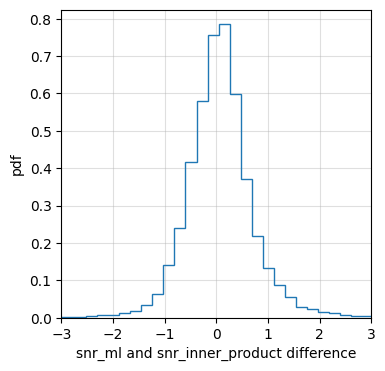

In [294]:
import matplotlib.pyplot as plt
hist_ = y_pred.flatten()-y_test
print(len(hist_))
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-3,3)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [140]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

ValueError: continuous is not supported